# Nested clustered portfolio optimization algorithm

## Патрашев Иван

# Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples
from sklearn.covariance import LedoitWolf
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from scipy.optimize import minimize
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt 
import getFamaFrenchFactors as gff
import statsmodels.api as sm
from pypfopt.efficient_frontier import EfficientFrontier
sns.set()

# Работа с данными

### Читаем данные из файла

In [2]:
df = pd.read_csv('/Users/ivanpatrashev/Downloads/indices.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df_monthly = df.resample('1M').last()

In [3]:
df_monthly

,Argentina: BNY Mellon Argentina ADR,Argentina: BNY Mellon Argentina ADR TR,Argentina: S&P Merval,Argentina: S&P/BYMA Argentina General,Australia: ASX All Ordinaries,Australia: ASX All Ordinaries Gold,Australia: ASX Small Ordinaries,Australia: BNY Mellon Australia ADR,Australia: BNY Mellon Australia ADR TR,Australia: FTSE Australia,...,World: TR/CC CRB Soybeans,World: TR/CC CRB Sugar,World: TR/CC CRB TR,World: TR/CC CRB Unleaded Gas,World: TR/CC CRB Wheat,World: TR/CC CRB ex Energy ER,World: TR/CC CRB ex Energy TR,World: WTI Futures Long USD,World: World Water CW,World: World Water TR CW
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,76.367048,108.037720,1339.703892,7.839665e+04,3398.132438,5941.769184,1745.878861,238.185961,379.017499,278.423446,...,12.218750,20.192512,267.335036,15.474482,3.486465,158.592126,283.042173,698.440477,1479.870405,1885.647422
2012-02-29,65.803028,93.091383,1272.915050,7.637912e+04,3447.120246,5973.174259,1853.559768,233.232078,374.502756,279.548308,...,13.337204,21.029867,276.017522,15.548054,3.338895,160.522368,286.506720,756.454565,1490.446025,1906.057644
2012-03-31,63.727375,90.155643,1290.108551,7.697868e+04,3472.171901,5274.824347,1845.900764,225.997619,362.912154,282.260743,...,14.183649,20.582772,264.075896,14.879310,3.023585,157.841122,281.745567,724.547531,1556.469910,1992.830875
2012-04-30,51.664840,73.087692,1092.010779,6.793320e+04,3509.274116,4930.596706,1826.973339,232.226144,372.921905,286.257595,...,15.201555,17.301552,261.945906,13.912509,2.859999,157.727157,281.557939,734.040356,1570.129734,2011.751610
2012-05-31,42.734077,61.416030,1084.743077,6.848870e+04,3334.182264,4524.717903,1689.779707,192.781116,313.905794,272.302376,...,13.189337,15.901056,233.725687,12.892887,2.838862,149.281712,266.497379,603.526515,1561.804067,2010.960054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,62.610000,99.150000,48432.270000,2.046378e+06,6940.600000,6415.400000,3123.900000,343.450000,805.350000,554.370000,...,11.729716,9.671500,196.558349,9.128238,1.994163,137.752562,260.957902,231.326489,4943.760000,7479.140000
2021-03-31,63.400000,100.400000,47982.390000,2.021651e+06,7017.000000,6217.000000,3130.800000,328.180000,779.520000,564.790000,...,11.561100,8.765500,196.560000,9.203600,1.838100,133.977815,253.819923,239.730000,5344.470000,8093.800000
2021-04-30,60.170000,95.300000,49056.100000,2.073069e+06,7290.700000,6890.700000,3285.500000,343.710000,816.410000,584.120000,...,12.294400,10.288400,212.290000,9.874500,2.142200,142.502722,269.973782,257.440000,5430.940000,8238.880000


### Посчитаем месячный return. Это понадобится при рассчете expected returns с помощью Fama-French 3 factor model

In [5]:
df_monthly_return = df_monthly.pct_change().dropna()

### Получаем данные о показателях модели Fama-French и соединяем с нашими данными. Возьмем период 2015-2020 чтобы избавиться от исторической ошибки и оставить один год для теста модели

In [6]:
ff3_monthly = pd.DataFrame(gff.famaFrench3Factor(frequency = 'm'))
ff3_monthly.rename(columns = {'date_ff_factors':'Date'}, inplace = True)
ff3_monthly.set_index('Date', inplace = True)
ff3_monthly.tail()#пример как выглядят показатели

,Mkt-RF,SMB,HML,RF
Date,,,,
2022-05-31,-0.0034,-0.0185,0.0841,0.0003
2022-06-30,-0.0843,0.0209,-0.0597,0.0006
2022-07-31,0.0957,0.0281,-0.0410,0.0008
2022-08-31,-0.0378,0.0139,0.0031,0.0019
2022-09-30,-0.0936,-0.0081,0.0005,0.0019


In [7]:
data = ff3_monthly.merge(df_monthly_return, on = 'Date')
data = data.loc['2015-06-01':'2020-06-01']

# Алогритм рассчета ожидаемой доходности активов методом Fama–French three-factor model

In [8]:
tickers = df.columns

In [9]:
ER={}
risk_free = data['RF'].mean()
market_premium = data['Mkt-RF'].mean()
size_premium = data['SMB'].mean()
value_premium = data['HML'].mean()
for i in tickers:
    X = data[['Mkt-RF','SMB','HML']]
    y = data[i] - data['RF']
    X1 = sm.add_constant(X)
    model = sm.OLS(y,X1)
    results = model.fit()
    intercept,beta_m,beta_s,beta_v = results.params
    ER[i] = (risk_free+beta_m*market_premium+beta_s*size_premium+beta_v*value_premium)*12

### Визуализируем полученные annual expected returns

<IPython.core.display.Javascript object>


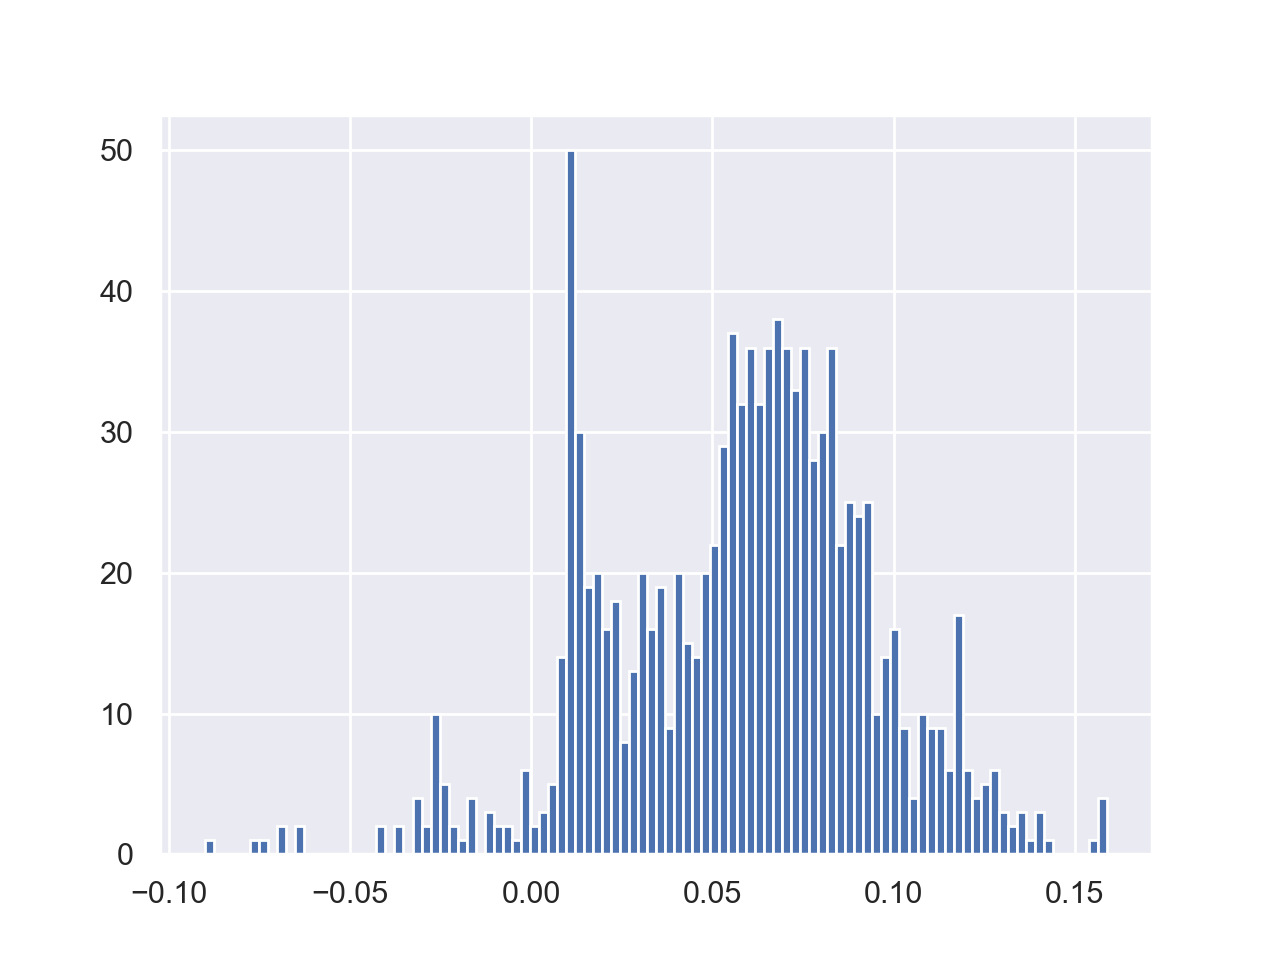

<AxesSubplot:>

In [25]:
%matplotlib notebook
fig,ax = plt.subplots()
pd.Series(ER.values()).hist(bins = 100, ax=ax)
#нужно перезапустить эту ячейку, чтобы увидеть гистограмму

# Алгоритм избавления от шумов в ковариационной матрице

### Применяем алгоритм Kernel Density Estimate (KDE) чтобы зафитить распределение с распределением Марченко-Пастура

In [11]:
def fitKDE(obs,bWidth,kernel='gaussian',x=None):
 # Fit kernel to a series of obs, and derive the prob of obs
 # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:
        obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:
        x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin[0],eMax[0],num=pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf,index=eVal)
    return pdf

def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    return sse

def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko's dist to the empirical one
    out=minimize(lambda *x:errPDFs(*x),.5,args=(eVal,q,bWidth),bounds=((1E-5,1-1E-5),))
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax,var

### Применяем функцию по избавлению от шумов в ковариационной матрице

In [12]:
def corr2cov(corr,std):
    cov=corr*np.outer(std,std)
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec

def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

# Nested Clustered Optimization

### Алгоритм кластеризации активов с помощью K-means

In [13]:
def clusterKMeansBase(corr0,maxNumClusters=30,n_init=10):
    dist,silh=((1-corr0.fillna(0))/2.)**.5,pd.Series(dtype = 'float64') # distance matrix
    if maxNumClusters is None:
        maxNumClusters=corr0.shape[0]//2
    for init in range(n_init):
        for i in range(2,maxNumClusters+1): # find optimal num clusters
            kmeans_=KMeans(n_clusters=i,n_init=1)
            kmeans_=kmeans_.fit(dist)
            silh_=silhouette_samples(dist,kmeans_.labels_)
            stat=(silh_.mean()/silh_.std(),silh.mean()/silh.std())
            if np.isnan(stat[1]) or stat[0]>stat[1]:
                silh,kmeans=silh_,kmeans_
    newIdx=np.argsort(kmeans.labels_)
    corr1=corr0.iloc[newIdx] # reorder rows
    corr1=corr1.iloc[:,newIdx] # reorder columns
    clstrs={i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} # cluster members
    silh=pd.Series(silh,index=dist.index)
    print(clstrs)
    return corr1,clstrs,silh

### Алгоритм улучшения кластеризации из статьи  López de Prado and Lewis [2019]

In [14]:
def makeNewOutputs(corr0,clstrs,clstrs2):
    clstrsNew,newIdx={},[]
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs2[i])
    map(newIdx.extend, list(clstrsNew.values()))
    corrNew=corr0.loc[newIdx,newIdx]
    dist=((1-corr0.fillna(0))/2.)**.5
    kmeans_labels=np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs=[dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs]=i
    silhNew=pd.Series(silhouette_samples(dist,kmeans_labels),index=dist.index)
    return corrNew,clstrsNew,silhNew

def clusterKMeansTop(corr0,maxNumClusters,n_init=3):
    corr1,clstrs,silh=clusterKMeansBase(corr0,maxNumClusters=corr0.shape[1]-1,n_init=n_init)
    clusterTstats={i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean=np.mean(list(clusterTstats.values()))
    redoClusters=[i for i in clusterTstats.keys() if clusterTstats[i]<tStatMean]
    if len(redoClusters)<=2:
        return corr1,clstrs,silh
    else:
        keysRedo=[];map(keysRedo.extend,[clstrs[i] for i in redoClusters])
        corrTmp=corr0.loc[keysRedo,keysRedo]
        meanRedoTstat=np.mean([clusterTstats[i] for i in redoClusters])
        corr2,clstrs2,silh2=clusterKMeansTop(corrTmp, \
        maxNumClusters=corrTmp.shape[1]-1,n_init=n_init)
        corrNew,clstrsNew,silhNew=makeNewOutputs(corr0, {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters},clstrs2)
        newTstatMean=np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) 
        for i in clstrsNew.keys()])
        if newTstatMean<=meanRedoTstat:
            return corr1,clstrs,silh
        else:
            return corrNew,clstrsNew,silhNew

### Определяем оптимальные веса в портфеле с помощью алгоритма NCO и алгоритма Mean Variance Optimization для получения Efficient Frontier и рассчета портфолио с максимальным sharpe ratio

In [15]:
def optPort(cov,mu):
    ef = EfficientFrontier(mu, cov ,weight_bounds = (-1,1))
    w = ef.max_sharpe()
    p = np.array(list([i] for i in ef.clean_weights().values()))
    return p
def optPort_nco(cov,mu,maxNumClusters=30):
    cov=pd.DataFrame(cov)
    mu=pd.Series(mu0[:,0])
    corr1=cov2corr(cov)
    #corr1,clstrs,_=clusterKMeansTop(corr1,maxNumClusters,n_init=10)
    #алгоритм работает очень долго, поэтому я вставил результат, который я получил при прошлой итерации
    clstrs = {0: [4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 118, 119, 120, 121, 122, 123, 124, 128, 129, 147, 148, 153, 163, 168, 178, 179, 180, 181, 182, 183, 185, 203, 204, 205, 206, 207, 208, 209, 222, 242, 243, 244, 245, 246, 247, 248, 255, 256, 257, 258, 259, 261, 264, 265, 266, 267, 268, 269, 270, 271, 317, 319, 337, 338, 339, 340, 341, 342, 368, 369, 370, 371, 372, 373, 375, 399, 400, 401, 404, 405, 428, 440, 441, 445, 446, 447, 449, 451, 452, 453, 454, 455, 456, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 529, 530, 531, 532, 533, 537, 539, 570, 614, 615, 616, 617, 622, 623, 624, 625, 626, 627, 628, 679, 698, 699, 707, 716, 717, 718, 719, 720, 721, 722, 723, 726, 736, 754, 757, 808, 812, 813, 814, 827, 836, 865, 866, 867, 868, 869, 871, 872, 907, 908, 909, 914, 915, 916, 917, 926, 931, 932, 933, 934, 935, 936, 937, 938, 939, 945, 946, 948, 949, 950, 951, 952, 953, 954, 960, 961, 962, 963, 964, 965, 966, 967, 972, 973, 978, 979, 986, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1005, 1011, 1012, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1044, 1051, 1060, 1061, 1063, 1066, 1068, 1070, 1072, 1073, 1075, 1078], 1: [0, 1, 2, 3, 7, 8, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 125, 126, 127, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 249, 250, 251, 252, 253, 254, 260, 262, 263, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 318, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 374, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 402, 403, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 442, 443, 444, 448, 450, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 534, 535, 536, 538, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 618, 619, 620, 621, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 700, 701, 702, 703, 704, 705, 706, 708, 709, 710, 711, 712, 713, 714, 715, 724, 725, 727, 728, 729, 730, 731, 732, 733, 734, 735, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 755, 756, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 809, 810, 811, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 828, 829, 830, 831, 832, 833, 834, 835, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 870, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 910, 911, 912, 913, 918, 919, 920, 921, 922, 923, 924, 925, 927, 928, 929, 930, 940, 941, 942, 943, 944, 947, 955, 956, 957, 958, 959, 968, 969, 970, 971, 974, 975, 976, 977, 980, 981, 982, 983, 984, 985, 987, 988, 989, 990, 1002, 1003, 1004, 1006, 1007, 1008, 1009, 1010, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1040, 1041, 1042, 1043, 1045, 1046, 1047, 1048, 1049, 1050, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1062, 1064, 1065, 1067, 1069, 1071, 1074, 1076, 1077, 1079, 1080, 1081, 1082, 1083]}
    wIntra=pd.DataFrame(0,index=cov.index,columns=clstrs.keys())
    for i in clstrs:
        cov_=cov.loc[clstrs[i],clstrs[i]].values
        mu_= mu.loc[clstrs[i]].values.reshape(-1,1)
        wIntra.loc[clstrs[i],i]=optPort(cov_,mu_).flatten()
    cov_=wIntra.T.dot(np.dot(cov,wIntra)) # reduce covariance matrix
    mu_= wIntra.T.dot(mu)
    wInter=pd.Series(optPort(cov_,mu_).flatten(),index=cov_.index)
    nco=wIntra.mul(wInter,axis=1).sum(axis=1).values.reshape(-1,1)
    return nco

# Применяем алгоритмы на наших данных

### Передаем ожидаемую доходность и ковариационную матрицу

In [16]:
mu0 = []
for i in ER.values():
    mu0.append([i])
mu0 = np.array(mu0)

In [17]:
cov = df_monthly_return.cov()*12
cov0 = LedoitWolf().fit(cov).covariance_
cov0 = pd.DataFrame(cov0)

### Получаем веса (-1;1) где вес меньше нуля соответствует шорт-позиции, а вес больше нуля - лонг-позиции

In [18]:
nco = optPort_nco(cov0,mu0,maxNumClusters=10)
nco

array([[-0.20965077],
       [-0.21444092],
       [ 0.37874866],
       ...,
       [ 0.01552614],
       [-0.03988338],
       [-0.00210416]])

In [19]:
for i in range(1084):
    print('{}:{},'.format(df.columns[i],nco[i]))

Argentina: BNY Mellon Argentina ADR:[-0.20965077],
Argentina: BNY Mellon Argentina ADR TR:[-0.21444092],
Argentina: S&P Merval:[0.37874866],
Argentina: S&P/BYMA Argentina General:[-0.35791429],
Australia: ASX All Ordinaries:[0.00130104],
Australia: ASX All Ordinaries Gold:[-0.04231722],
Australia: ASX Small Ordinaries:[0.04861334],
Australia: BNY Mellon Australia ADR:[-0.60058602],
Australia: BNY Mellon Australia ADR TR:[-0.61317112],
Australia: FTSE Australia:[-0.0824728],
Australia: S&P/ASX 100:[-0.05896076],
Australia: S&P/ASX 100 Industrials:[-0.06960653],
Australia: S&P/ASX 100 Resources:[-0.059661],
Australia: S&P/ASX 20:[-0.06493619],
Australia: S&P/ASX 200:[-0.04223806],
Australia: S&P/ASX 200 Accumulated:[-0.02470145],
Australia: S&P/ASX 200 Banks:[-0.01325597],
Australia: S&P/ASX 200 Captal Goods Size:[-0.01499136],
Australia: S&P/ASX 200 Commercial & Professional Services:[0.07612187],
Australia: S&P/ASX 200 Consumer Discretionary:[-0.13949519],
Australia: S&P/ASX 200 Consum

In [20]:
mu0

array([[0.04098577],
       [0.04640824],
       [0.11960648],
       ...,
       [0.11416071],
       [0.06127613],
       [0.05715864]])

In [21]:
cov0

,0,1,2,3,4,5,6,7,8,9,...,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083
0,0.000147,0.000149,0.000102,0.000082,0.000013,1.465066e-06,0.000016,0.000058,0.000054,0.000012,...,2.962424e-05,2.005354e-05,0.000041,0.000073,0.000015,2.360418e-05,2.245196e-05,0.000079,1.031300e-05,1.095569e-05
1,0.000149,0.000151,0.000102,0.000083,0.000013,2.591541e-06,0.000017,0.000059,0.000055,0.000013,...,2.962115e-05,2.073142e-05,0.000041,0.000075,0.000015,2.383620e-05,2.267316e-05,0.000081,1.031134e-05,1.094934e-05
2,0.000102,0.000102,0.000098,0.000084,0.000008,7.361113e-06,0.000010,0.000042,0.000039,0.000007,...,1.381770e-05,1.348339e-05,0.000027,0.000045,0.000005,1.610241e-05,1.526421e-05,0.000046,8.731750e-06,8.659846e-06
3,0.000082,0.000083,0.000084,0.000074,0.000006,1.184778e-05,0.000008,0.000036,0.000033,0.000006,...,1.159789e-05,1.319213e-05,0.000022,0.000035,0.000005,1.421372e-05,1.355204e-05,0.000035,6.023895e-06,5.907925e-06
4,0.000013,0.000013,0.000008,0.000006,0.000008,9.979581e-07,0.000009,0.000011,0.000010,0.000008,...,2.640792e-06,3.617773e-06,0.000007,0.000016,-0.000002,2.571980e-06,2.355023e-06,0.000018,4.992800e-06,5.054170e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,0.000024,0.000024,0.000016,0.000014,0.000003,7.650550e-06,0.000004,0.000020,0.000019,0.000002,...,1.677158e-05,1.639371e-05,0.000019,0.000026,0.000012,1.207453e-05,1.175901e-05,0.000032,7.535260e-07,1.012478e-06
1080,0.000022,0.000023,0.000015,0.000014,0.000002,8.030150e-06,0.000004,0.000019,0.000018,0.000002,...,1.648072e-05,1.624419e-05,0.000018,0.000025,0.000012,1.175901e-05,1.169473e-05,0.000031,5.018524e-07,7.558111e-07
1081,0.000079,0.000081,0.000046,0.000035,0.000018,-1.501555e-06,0.000028,0.000062,0.000059,0.000015,...,4.396350e-05,4.370016e-05,0.000072,0.000127,0.000011,3.181807e-05,3.068848e-05,0.000157,1.304428e-05,1.420223e-05
1082,0.000010,0.000010,0.000009,0.000006,0.000005,-5.500999e-06,0.000007,0.000006,0.000006,0.000005,...,2.301157e-07,8.125254e-07,0.000005,0.000014,-0.000005,7.535260e-07,5.018524e-07,0.000013,8.032267e-06,7.827277e-06


In [22]:
weights = [i[0] for i in nco]
weights = np.array(weights)
weights

array([-0.20965077, -0.21444092,  0.37874866, ...,  0.01552614,
       -0.03988338, -0.00210416])

In [23]:
data = pd.DataFrame()
data['indexies'] = df.columns
data['weights'] = nco
data.sort_values('weights',inplace = True)
data

,indexies,weights
541,Portugal: Basic Materials GR,-0.79703
848,United states: S&P Oil & Gas Exploration & Pro...,-0.79703
299,France: CAC Consumer Service,-0.79703
701,Turkey: Non-Metal Mineral,-0.79703
638,Sweden: Pharmaceuticals & Biotechnology PI,-0.79703
...,...,...
576,South africa: TR South Africa 50,0.79703
621,Sweden: Health Care Equipment & Services GI,0.79703
653,Sweden: Stockholm Personal Goods,0.79703
674,Taiwan: BNY Mellon Taiwan ADR,0.79703
